## Library

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from skimage import io

## Data Exploration

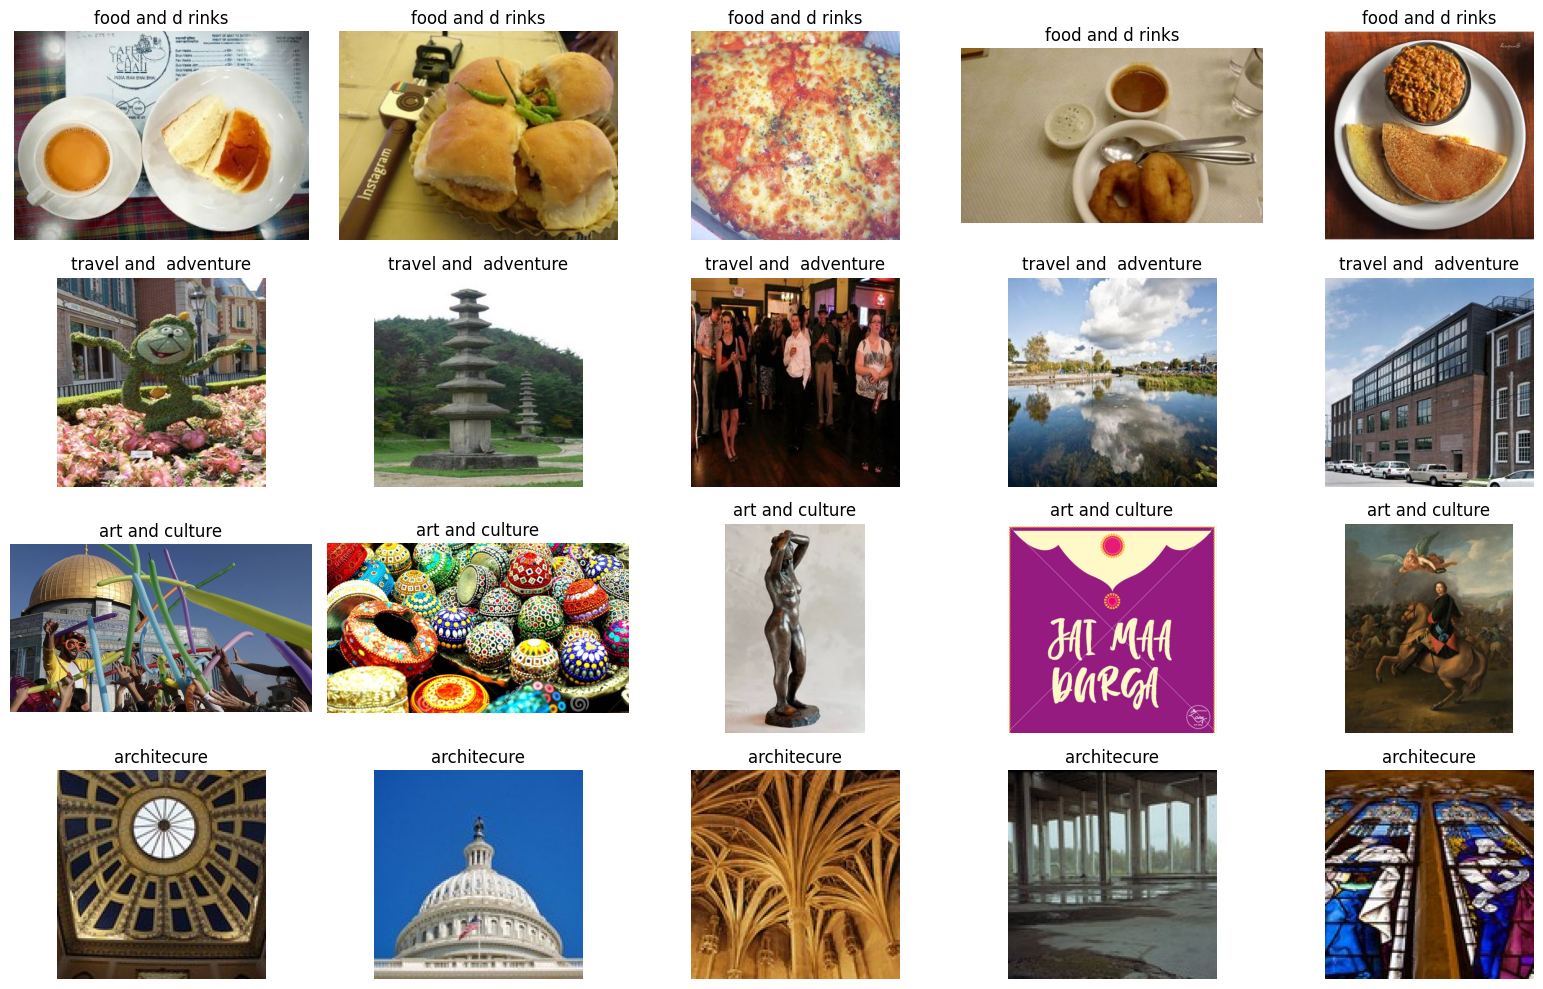

In [50]:
image_dir = '/kaggle/input/image-classification/images/images'
val_dir = '/kaggle/input/image-classification/validation/validation'
classes = os.listdir(image_dir) 

# Plot samples from each class
plt.figure(figsize=(16, 10))

for i, label in enumerate(classes):
    class_dir = os.path.join(image_dir, label)
    images = os.listdir(class_dir)[:5]
    
    for j, image_file in enumerate(images):
        image_path = os.path.join(class_dir, image_file)
        img = Image.open(image_path)
        
        ax = plt.subplot(len(classes), 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [51]:
def count_original_images(image_dir):
    class_counts = {}
    classes = os.listdir(image_dir)
    
    for label in classes:
        class_dir = os.path.join(image_dir, label)
        class_counts[label] = len(os.listdir(class_dir))
    
    return class_counts

original_counts = count_original_images(image_dir)
print("Original Image Counts per Class:", original_counts)

Original Image Counts per Class: {'food and d rinks': 8782, 'travel and  adventure': 8800, 'art and culture': 8750, 'architecure': 8763}


In [158]:
image_size = (224, 224)
batch_size = 32

# try augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20, 
    zoom_range=0.2,
    horizontal_flip=True
)

# training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.3,
    image_size=image_size,
    batch_size=batch_size,
    subset='training',
    seed=42,
    shuffle=True
)

# validation data
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.3,
    image_size=image_size,
    batch_size=batch_size,
    subset='validation',
    seed=42,
    shuffle=True
)

# test data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=image_size,
    batch_size=1
)

class_id = train_data.class_names
print("Classes:", class_id)

Found 35093 files belonging to 4 classes.
Using 24566 files for training.
Found 35093 files belonging to 4 classes.
Using 10527 files for validation.
Found 122 files belonging to 4 classes.
Classes: ['architecure', 'art and culture', 'food and d rinks', 'travel and  adventure']


## Preprocessing Exploration

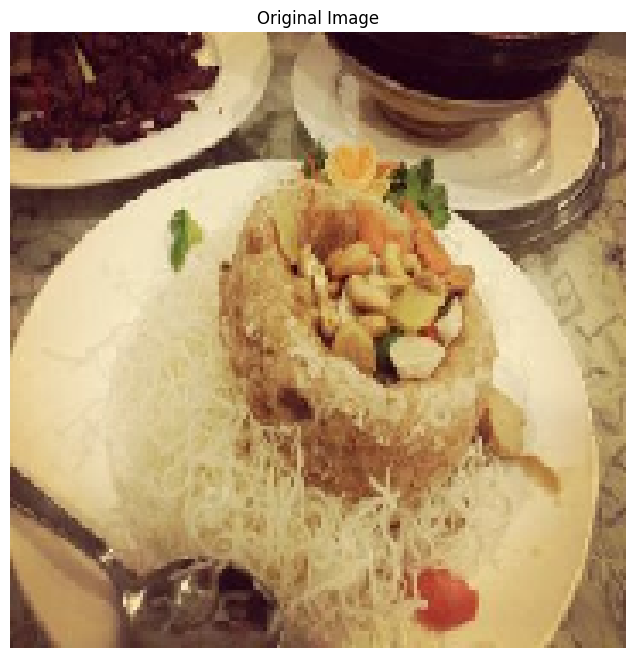

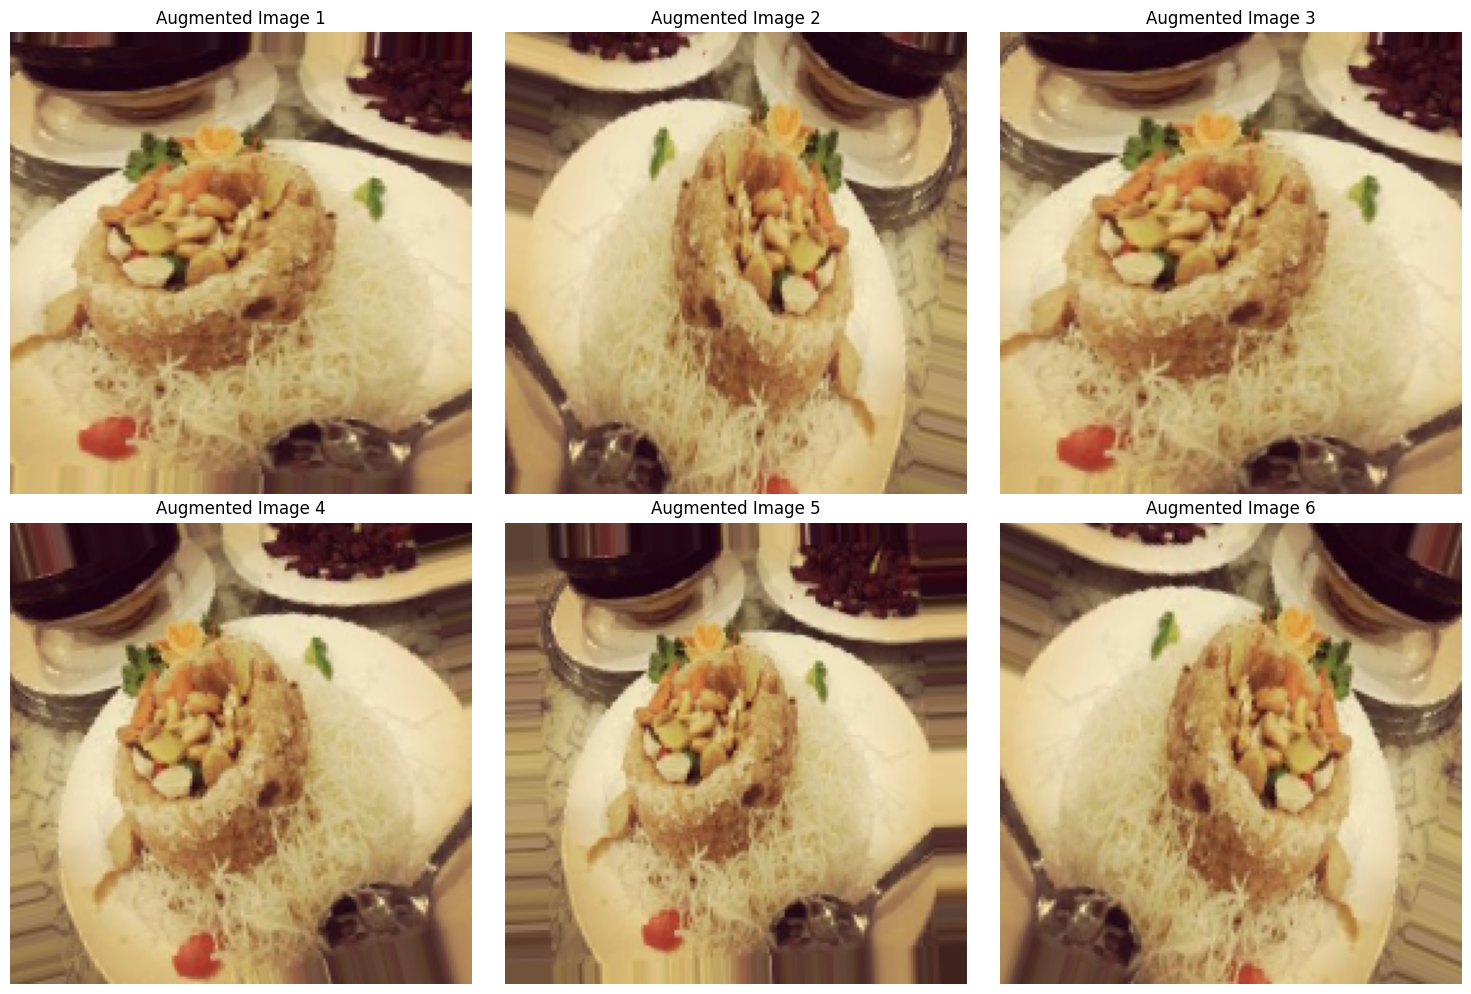

In [182]:
image_path = '/kaggle/input/image-classification/images/images/food and d rinks/00EcStbZvxP42pgwGx3W.jpg'
target_size = (180, 180)

original_image = load_img(image_path, target_size=target_size)
original_image_array = img_to_array(original_image) / 255.0 

plt.figure(figsize=(8, 8))
plt.imshow(original_image_array)
plt.title("Original Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(15, 10))
for i in range(6):
    augmented_image = train_gen.random_transform(original_image_array)
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_image)
    plt.title(f"Augmented Image {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Exp 1

In [169]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))

base_model.trainable = True

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),  # Rescale images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_id), activation='softmax')
])

initial_learning_rate = 0.0001 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_37 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,796 (23.21 MB)

 Trainable params: 6,023,188 (22.98 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [170]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 267s 224ms/step - accuracy: 0.7768 - loss: 0.5785 - val_accuracy: 0.5797 - val_loss: 1.0692 - learning_rate: 1.0000e-04
Epoch 2/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 103s 134ms/step - accuracy: 0.9434 - loss: 0.1733 - val_accuracy: 0.9483 - val_loss: 0.1550 - learning_rate: 1.0000e-04
Epoch 3/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 101s 131ms/step - accuracy: 0.9640 - loss: 0.1094 - val_accuracy: 0.9383 - val_loss: 0.2092 - learning_rate: 1.0000e-04
Epoch 4/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 101s 131ms/step - accuracy: 0.9745 - loss: 0.0746 - val_accuracy: 0.9182 - val_loss: 0.2486 - learning_rate: 1.0000e-04
Epoch 5/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 108s 140ms/step - accuracy: 0.9859 - loss: 0.0420 - val_accuracy: 0.9687 - val_loss: 0.1117 - learning_rate: 2.0000e-05
Epoch 6/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 101s 131ms/step - accuracy: 0.9906 - loss: 0.0312 - val_accuracy: 0.9114 - val_loss: 0.2975 - learning_rate: 2.0000e-05
Epoch 7/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 

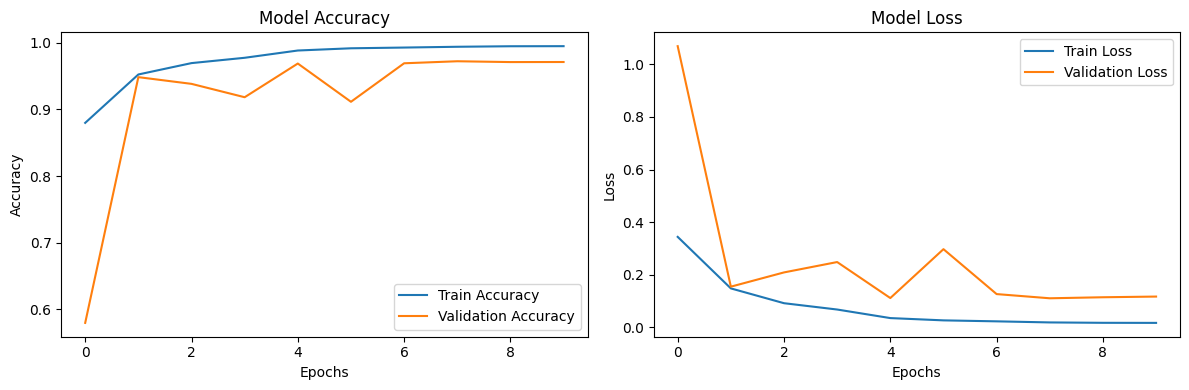

In [171]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [173]:
loss, accuracy = model.evaluate(test_data, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8283 - loss: 1.2088
Test Loss: 1.4918509721755981
Test Accuracy: 0.8032786846160889


## Exp 2

In [ ]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))

base_model.trainable = True
for layer in base_model.layers[:10]:
    layer.trainable = False

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),  # Rescale images
    layers.RandomRotation(0.2),  # Random rotation
    layers.RandomZoom(0.2),      # Random zoom
    layers.RandomFlip("horizontal"),  # Random horizontal flip
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_id), activation='softmax')
])

initial_learning_rate = 0.0001 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

model.summary()


In [160]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


2024-10-06 09:25:04.704422: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_17_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


768/768 ━━━━━━━━━━━━━━━━━━━━ 237s 252ms/step - accuracy: 0.6817 - loss: 0.7781 - val_accuracy: 0.8561 - val_loss: 0.3833 - learning_rate: 1.0000e-04
Epoch 2/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 192s 250ms/step - accuracy: 0.8804 - loss: 0.3404 - val_accuracy: 0.8833 - val_loss: 0.3189 - learning_rate: 1.0000e-04
Epoch 3/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 191s 248ms/step - accuracy: 0.9018 - loss: 0.2734 - val_accuracy: 0.8578 - val_loss: 0.3932 - learning_rate: 1.0000e-04
Epoch 4/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 191s 249ms/step - accuracy: 0.9168 - loss: 0.2405 - val_accuracy: 0.8770 - val_loss: 0.3566 - learning_rate: 1.0000e-04
Epoch 5/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 191s 249ms/step - accuracy: 0.9353 - loss: 0.1936 - val_accuracy: 0.8966 - val_loss: 0.3108 - learning_rate: 2.0000e-05
Epoch 6/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 191s 249ms/step - accuracy: 0.9399 - loss: 0.1763 - val_accuracy: 0.8988 - val_loss: 0.2913 - learning_rate: 2.0000e-05
Epoch 7/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 191s 249ms/

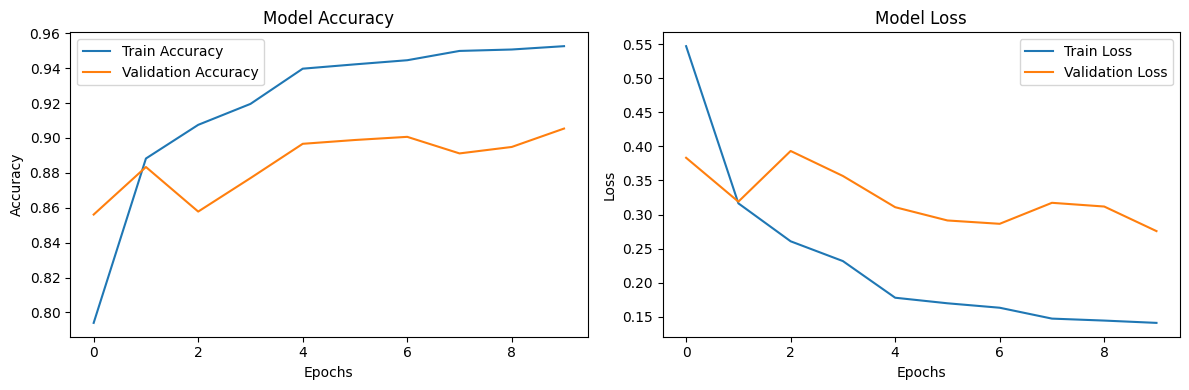

In [161]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [162]:
loss, accuracy = model.evaluate(test_data, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8525 - loss: 0.7139
Test Loss: 0.9357956647872925
Test Accuracy: 0.811475396156311


## Exp 3

In [93]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))

base_model.trainable = True
for layer in base_model.layers[:10]:
    layer.trainable = False


# Create the model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),  # Rescale images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_id), activation='softmax')
])

initial_learning_rate = 0.0001 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_29 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,796 (23.21 MB)

 Trainable params: 6,008,404 (22.92 MB)

 Non-trainable params: 75,392 (294.50 KB)

In [95]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 246s 197ms/step - accuracy: 0.7560 - loss: 0.6411 - val_accuracy: 0.9426 - val_loss: 0.1807 - learning_rate: 1.0000e-04
Epoch 2/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 92s 119ms/step - accuracy: 0.9286 - loss: 0.2132 - val_accuracy: 0.9478 - val_loss: 0.1557 - learning_rate: 1.0000e-04
Epoch 3/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 92s 120ms/step - accuracy: 0.9472 - loss: 0.1517 - val_accuracy: 0.9561 - val_loss: 0.1457 - learning_rate: 1.0000e-04
Epoch 4/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 91s 118ms/step - accuracy: 0.9651 - loss: 0.1054 - val_accuracy: 0.9584 - val_loss: 0.1479 - learning_rate: 1.0000e-04
Epoch 5/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 91s 119ms/step - accuracy: 0.9735 - loss: 0.0772 - val_accuracy: 0.9549 - val_loss: 0.1598 - learning_rate: 1.0000e-04
Epoch 6/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 91s 118ms/step - accuracy: 0.9818 - loss: 0.0497 - val_accuracy: 0.9615 - val_loss: 0.1399 - learning_rate: 2.0000e-05
Epoch 7/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 91s 1

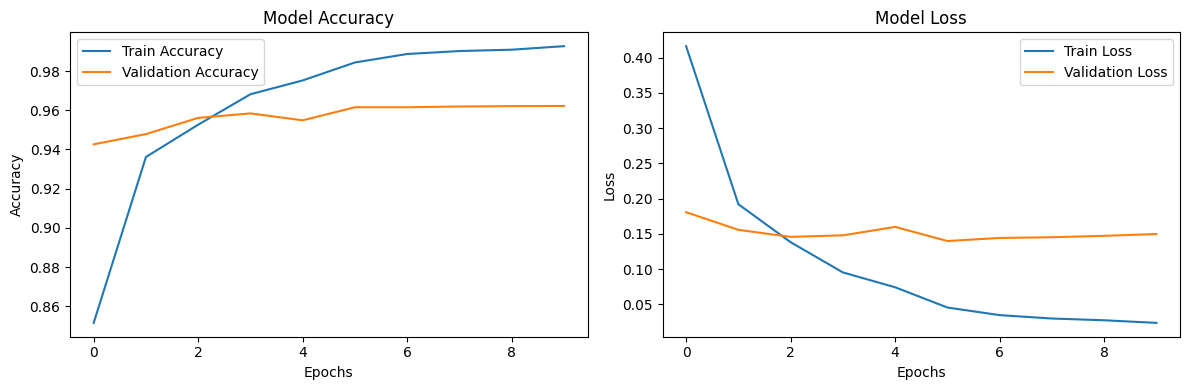

In [96]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [117]:
loss, accuracy = model.evaluate(test_data, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8999 - loss: 0.3138
Test Loss: 0.46137386560440063
Test Accuracy: 0.8852459192276001


In [118]:
y_pred = []
y_true = []

for images, labels in test_data:  
    preds = model.predict(images)  
    y_pred.extend(np.argmax(preds, axis=1))  # Ambil kelas dengan probabilitas tertinggi
    y_true.extend(labels.numpy())  

y_true = np.array(y_true).flatten()

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_true, y_pred, target_names=class_id)
print("Classification Report:")
print(class_report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [156]:
model.save('EfficientNetV2B0_v1.h5')

In [157]:

!zip -r EfficientNetV2B0_v1.zip EfficientNetV2B0_v1/

from IPython.display import FileLink
FileLink(r'EfficientNetV2B0_v1.h5')


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


	zip warning: name not matched: EfficientNetV2B0_v1/

zip error: Nothing to do! (try: zip -r EfficientNetV2B0_v1.zip . -i EfficientNetV2B0_v1/)


/kaggle/working/EfficientNetV2B0_v1.h5

## Predict test dir

In [175]:
from tensorflow.keras.models import load_model

model = load_model('EfficientNetV2B0_v1.h5')  # Load the saved model


Found 10 files belonging to 1 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


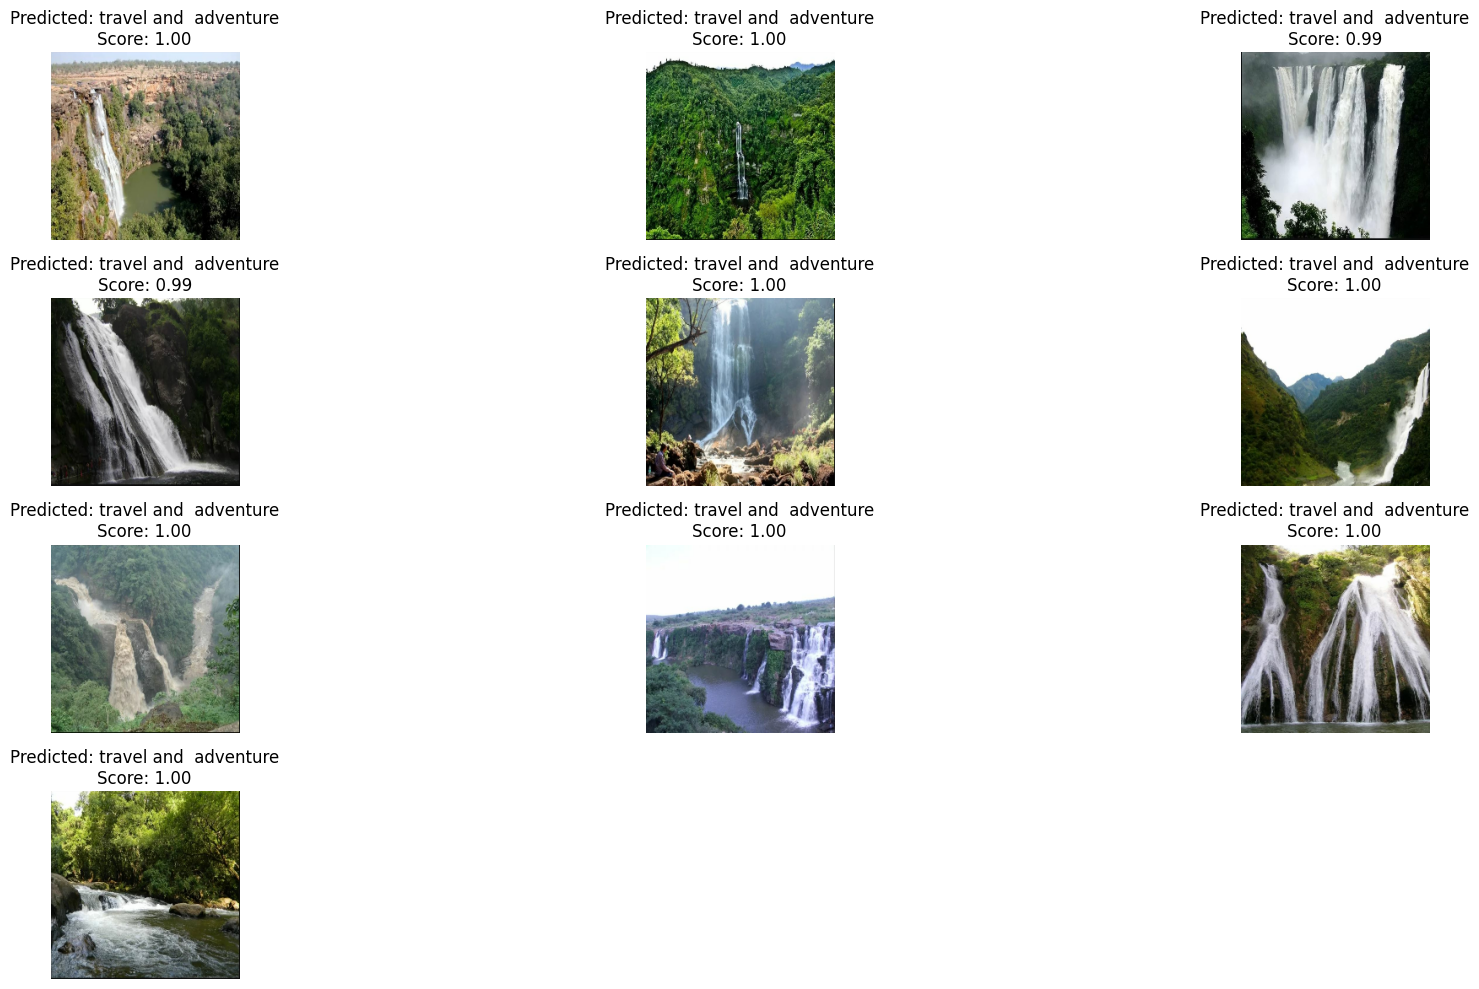

In [178]:
test_data_predict = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/image-classification/test/test', 
    image_size=(224, 224),
    batch_size=1,
    shuffle=False 
)

predictions = model.predict(test_data_predict)

class_names = train_data.class_names

plt.figure(figsize=(18, 10))
for i, (images, labels) in enumerate(test_data_predict):
#     if i >= 9: 
#         break
    ax = plt.subplot(4, 3, i + 1)
    predicted_class_index = np.argmax(predictions[i]) 
    predicted_class = class_names[predicted_class_index]  
    confidence_score = predictions[i][predicted_class_index] 

    plt.imshow(images[0].numpy().astype("uint8")) 
    plt.title(f'Predicted: {predicted_class}\nScore: {confidence_score:.2f}')
    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


(-0.5, 1264.5, 710.5, -0.5)

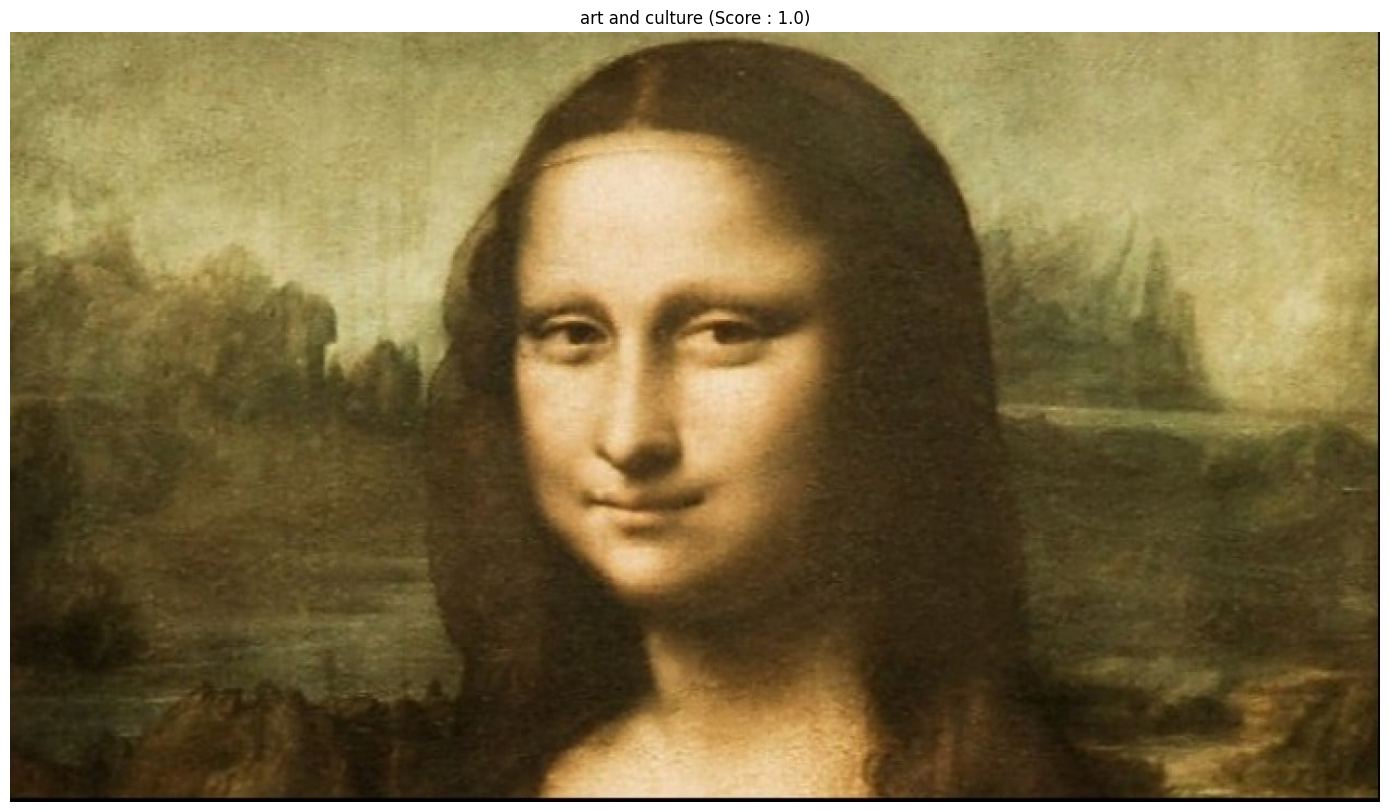

In [179]:
# custom image
plt.figure(figsize=(18, 10))
image_url = "https://thumb.viva.co.id/media/frontend/thumbs3/2020/09/02/5f4f1b90965aa-inilah-6-fakta-lukisan-mona-lisa-yang-jarang-diketahui_1265_711.jpg"
image_path = tf.keras.utils.get_file('5f4f1b90965aa-inilah-6-fakta-lukisan-mona-lisa-yang-jarang-diketahui_1265_711.jpg', origin=image_url)
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)  
predicted_class = class_names[predicted_class_index]
confidence_score = predictions[0][predicted_class_index]  
plt.title(predicted_class+' (Score : '+str (round(confidence_score,2))+')')
image = io.imread(image_url)
plt.imshow(image)
plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(-0.5, 562.5, 338.5, -0.5)

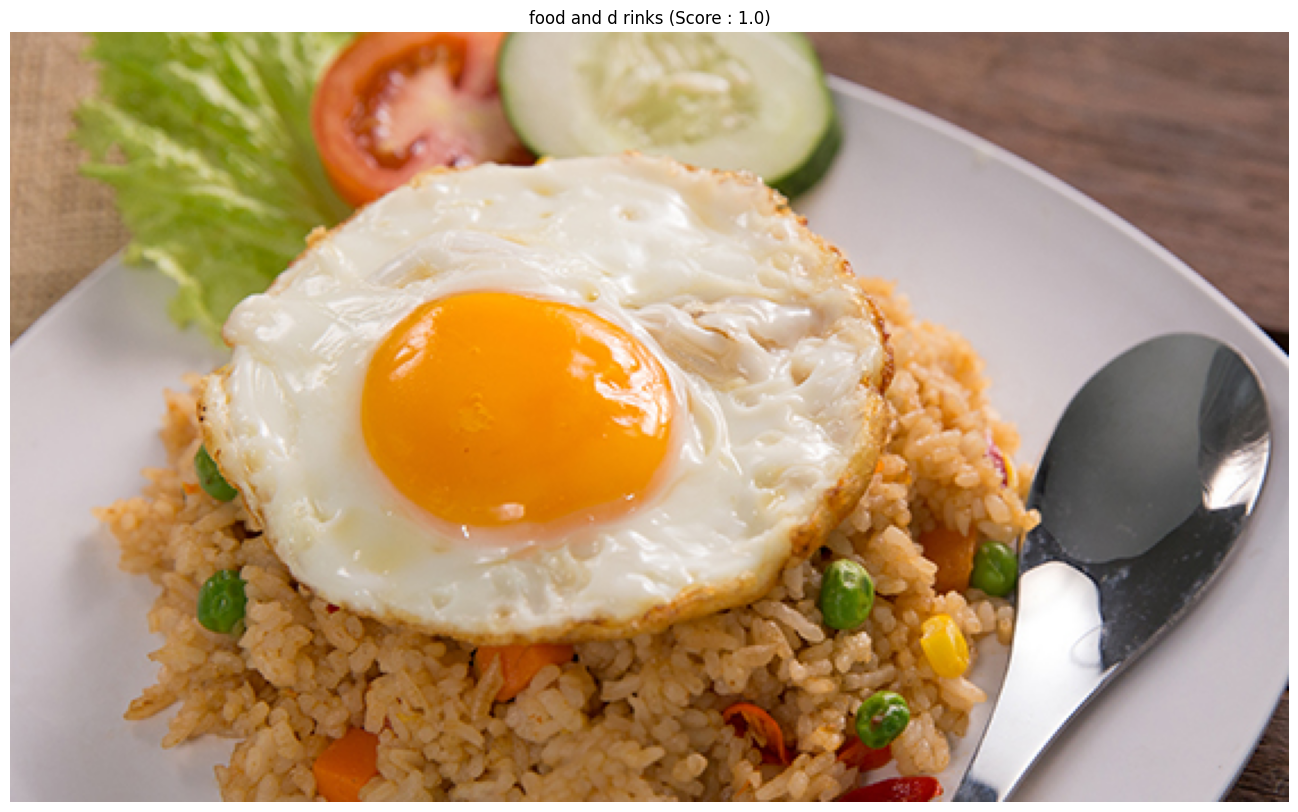

In [180]:
plt.figure(figsize=(18, 10))
image_url = "https://aslimasako.com/storage/post/new-title-14082023-084552.jpg"
image_path = tf.keras.utils.get_file('new-title-14082023-084552.jpg', origin=image_url)
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions) 
predicted_class = class_names[predicted_class_index]  
confidence_score = predictions[0][predicted_class_index] 
plt.title(predicted_class+' (Score : '+str (round(confidence_score,2))+')')
image = io.imread(image_url)
plt.imshow(image)
plt.axis("off")